In [35]:
# 라이브러리 로드 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV,cross_val_score,cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,IsolationForest
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest,f_classif
import shap
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report,RocCurveDisplay
import warnings
import missingno as msno 
warnings.filterwarnings(action='ignore',category=FutureWarning)


In [2]:
# 데이터 로드 및 데이터 샘플 확인 
df=pd.read_excel('./E Commerce Dataset.xlsx',sheet_name=1)
df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


# 2.데이터 이해 및 확인 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In [4]:
# 범주형 변수 통계 요약 확인 
df.select_dtypes(include='O').describe()

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5630,5630,5630,5630,5630
unique,3,7,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,2765,2314,3384,2050,2986


In [5]:
# 숫자형 변수 통계 요약 확인 
df.iloc[:,2:].describe()

,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5366.000000,5630.000000,5379.000000,5375.000000,5630.000000,5630.000000,5630.000000,5630.000000,5365.000000,5374.000000,5372.000000,5323.000000,5630.000000
mean,10.189899,1.654707,15.639896,2.931535,3.688988,3.066785,4.214032,0.284902,15.707922,1.751023,3.008004,4.543491,177.223030
std,8.557241,0.915389,8.531475,0.721926,1.023999,1.380194,2.583586,0.451408,3.675485,1.894621,2.939680,3.654433,49.207036
min,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.280000
75%,16.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.392500
max,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,324.990000


## 2-2.데이터 가공 

In [6]:
# PreferredLoginDevice 선호하는 로그인 디바이스  확인 
df['PreferredLoginDevice'].value_counts()

PreferredLoginDevice
Mobile Phone    2765
Computer        1634
Phone           1231
Name: count, dtype: int64

In [7]:
# Mobile Phone과 Phone은 =>  'Mobile'로 대체 , Computer은 'Web'으로 대체

df['PreferredLoginDevice']=df['PreferredLoginDevice'].str.replace('Mobile Phone','Mobile')
df['PreferredLoginDevice']=df['PreferredLoginDevice'].str.replace('Phone','Mobile')
df['PreferredLoginDevice']=df['PreferredLoginDevice'].str.replace('Computer','Web')

In [8]:
# PreferredPaymentMode 결제방식 데이터 확인 
df['PreferredPaymentMode'].value_counts()

PreferredPaymentMode
Debit Card          2314
Credit Card         1501
E wallet             614
UPI                  414
COD                  365
CC                   273
Cash on Delivery     149
Name: count, dtype: int64

In [9]:
df['PreferredPaymentMode']=df['PreferredPaymentMode'].str.replace('CC','Credit Card')
df['PreferredPaymentMode']=df['PreferredPaymentMode'].str.replace('COD','Cash on Delivery')

- Debit Card :직불 카드
- Credit Card:신용 카드 
- E Wallet: 전자 지갑 서비스 
- UPI (Unified Payments Interface): 은행 앱 계좌이체
- COD (Cash on Delivery ) :배송 후 대금 지급
- CC:신용 카드 약자

    - 'CC'카드도 신용 카드의 의미로, CC 는 Credit Card로 변경 
    - 'COD'는 Cash on Delivery와 같은의미로, Cash on Delivery로 변경 


In [10]:
# PreferedOrderCat 선호하는 카테고리 값 확인 
df['PreferedOrderCat'].value_counts()

PreferedOrderCat
Laptop & Accessory    2050
Mobile Phone          1271
Fashion                826
Mobile                 809
Grocery                410
Others                 264
Name: count, dtype: int64

In [11]:
# Mobile Phone 은 'Mobile'로 대체, Laptop&Accessory 는 'Laptop'으로 대체 
df['PreferedOrderCat']=df['PreferedOrderCat'].str.replace('Mobile Phone','Mobile')
df['PreferedOrderCat']=df['PreferedOrderCat'].str.replace('Laptop & Accessory','Laptop')

In [12]:
# 숫자형 컬럼  => 카테고리형 컬럼 변환

df['Churn']=df['Churn'].astype('category')
df['CityTier']=df['CityTier'].astype('category')
df['Complain']=df['Complain'].astype('category')

## EDA

### 1.이탈 여부 불균형 확인 
- 이탈 고객 16.8%, 잔존 고객 83.2%로 타겟 데이터의 불균형이 심하다.

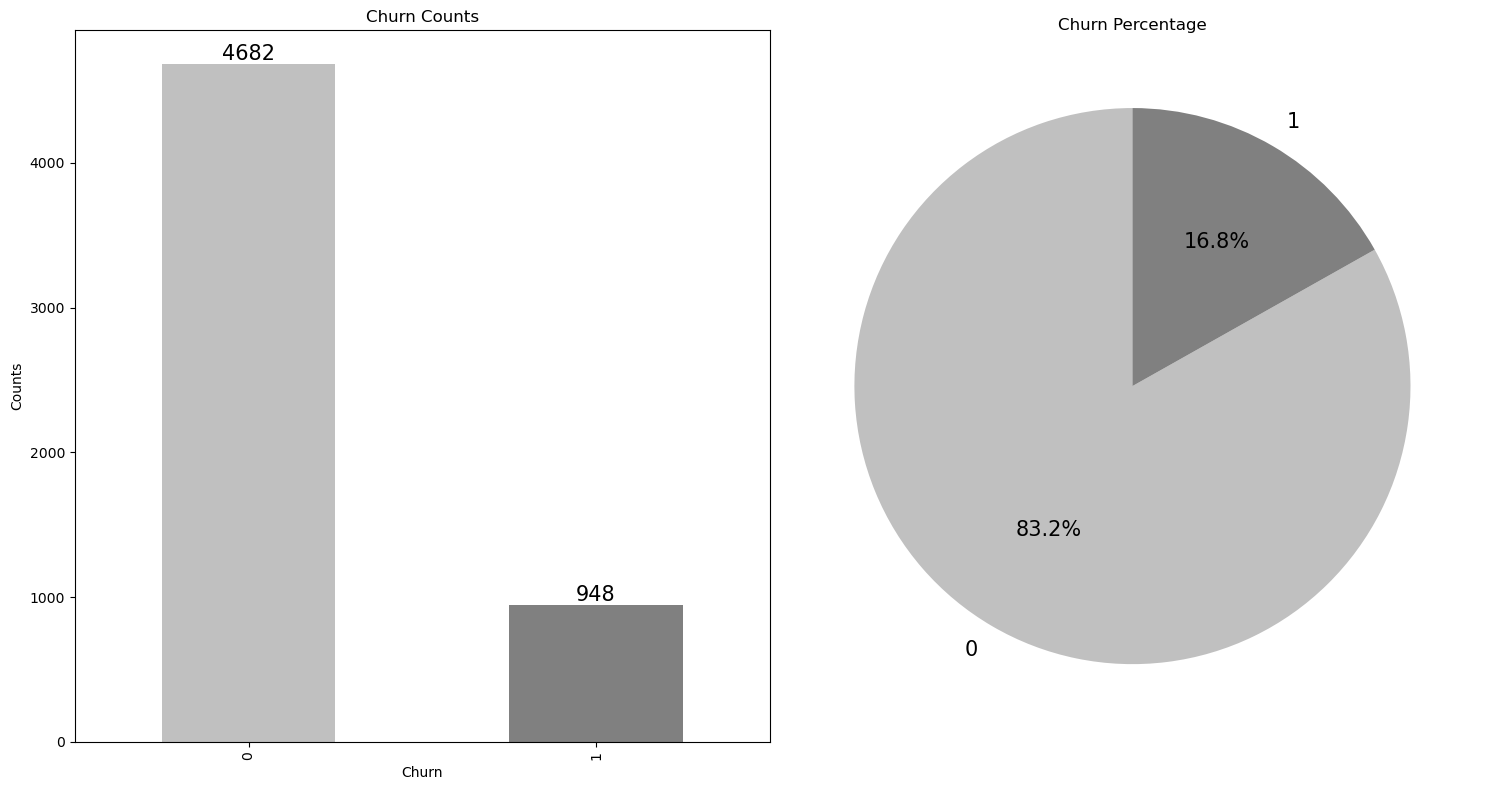

In [13]:
churn_counts = df['Churn'].value_counts()


fig, ax = plt.subplots(1, 2, figsize=(15, 8))

churn_counts.plot(kind='bar', ax=ax[0], color=['silver', 'grey'])
ax[0].set_title('Churn Counts')
ax[0].set_xlabel('Churn')
ax[0].set_ylabel('Counts')

# 숫자를 표시합니다.
for i, count in enumerate(churn_counts):
    ax[0].text(i, count, str(count), ha='center', va='bottom',size=15)

# 두 번째 서브플롯에 파이 차트
churn_counts.plot(kind='pie', ax=ax[1], colors=['silver', 'grey'], autopct='%1.1f%%', startangle=90)
ax[1].set_ylabel('')  # Y 레이블을 제거하여 파이 차트를 간결하게 함 
ax[1].set_title('Churn Percentage')

# 파이 차트의 비율이 0에 가까운 경우 % 수치가 겹쳐 보이지 않도록 조정합니다.
plt.setp(ax[1].texts, size=15)  # 텍스트 크기 조정
plt.tight_layout()

# 그래프를 표시합니다.
plt.show()

### 2. 사용기간 (Tenure)에 따른 이탈 
- 사용기간이 짧을수록 이탈율이 높다. => 사용 기간이 10일 이내인 고객의 이탈율이 24.4%로 가장 높다.
- 사용 기간이 30일이 넘어가는 고객부터는 이탈율이 없는 충성적인 고객으로 변환되는 것을 알 수 있다. 


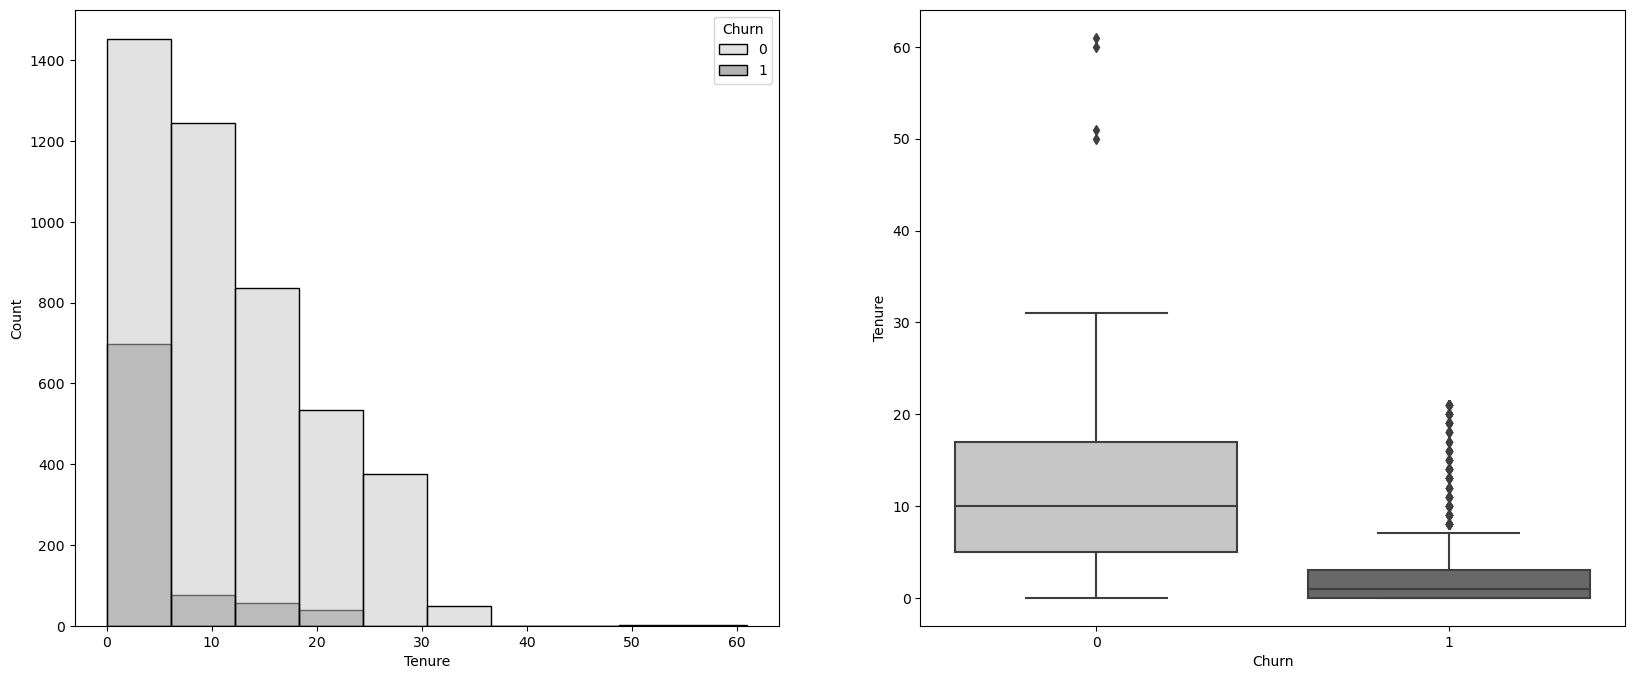

In [14]:
fig,ax=plt.subplots(1,2,figsize=(20,8))

sns.histplot(x=df['Tenure'],ax=ax[0],hue=df['Churn'],bins=10,palette='Greys')
sns.boxplot(y=df['Tenure'],x=df['Churn'],ax=ax[1],palette='Greys')
plt.show()


In [15]:
# 수치형 변수 바이닝 함수 생성 

def bin_tenure(df, num_bins):
    # 데이터프레임 복사본 생성
    df_copy = df.copy()

    # 'Tenure' 변수가 있는 행만 고려하여 바이닝 수행
    bins = pd.cut(df_copy.loc[df_copy['Tenure'].notnull(), 'Tenure'], num_bins, labels=False)

    # 1을 더하여 0이 아닌 값을 할당 (pd.cut은 0부터 레이블을 시작함)
    df_copy['Tenure_cat'] = bins + 1
    
    # 'Tenure_cat'이 0인 행을 제거 (결측치를 가진 행들)
    df_copy = df_copy[df_copy['Tenure_cat'].notnull()]

    return df_copy


df_ex = bin_tenure(df, 6)

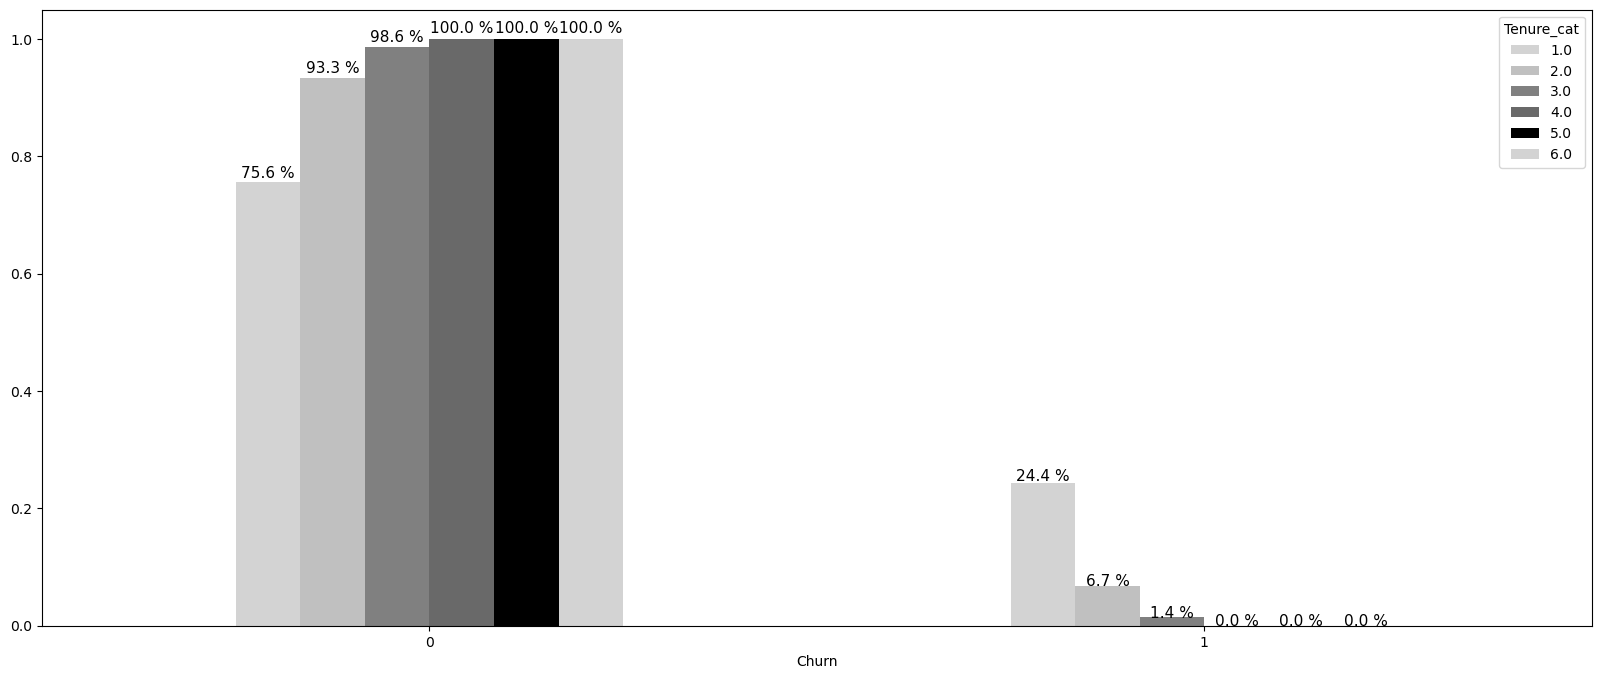

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))

# crosstab을 사용하여 정규화된 교차표 생성 및 시각화
pd.crosstab(df_ex['Tenure_cat'], df_ex['Churn'], normalize='index').T.plot.bar(rot=0, color=['lightgrey','silver', 'grey','dimgrey','black'], ax=ax)

# 퍼센트 값 표시
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f %%" % (height * 100), (left + width / 2, height * 1.01), ha='center',size=11)

plt.show()

### 3.컴플레인 여부에 따른 이탈 
- 컴플레인이 있는 고객의 이탈율은 약 21% 더 높다. 


In [17]:
pd.crosstab(df['Complain'],df['Churn'],margins=True)

Churn,0,1,All
Complain,,,
0,3586,440,4026
1,1096,508,1604
All,4682,948,5630


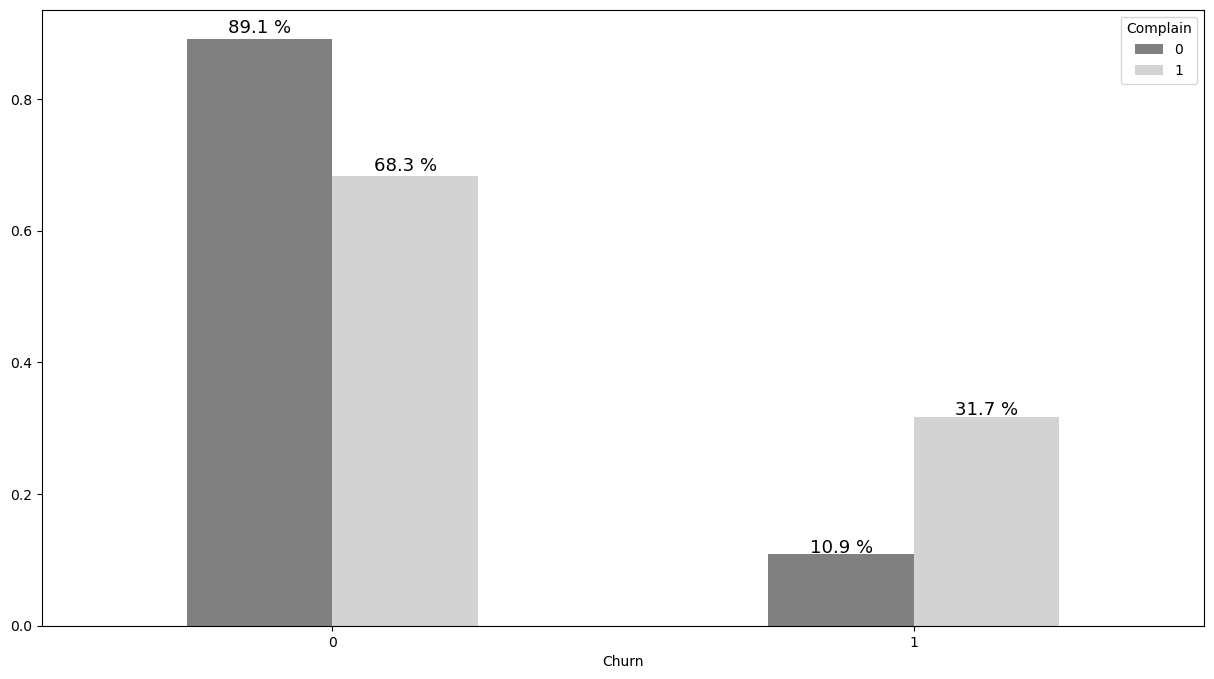

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))

# crosstab을 사용하여 정규화된 교차표 생성 및 시각화
pd.crosstab(df['Complain'], df['Churn'], normalize='index').T.plot.bar(rot=0, color=['grey', 'lightgrey'], ax=ax)

# 퍼센트 값 표시
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f %%" % (height * 100), (left + width / 2, height * 1.01), ha='center',size=13)

plt.show()

### 4.결혼상태에 따른 이탈 
- 싱글 고객의 이탈율은 26%로  가장 높다. 

In [19]:
pd.crosstab(df['MaritalStatus'],df['Churn'],margins=True)

Churn,0,1,All
MaritalStatus,,,
Divorced,724,124,848
Married,2642,344,2986
Single,1316,480,1796
All,4682,948,5630


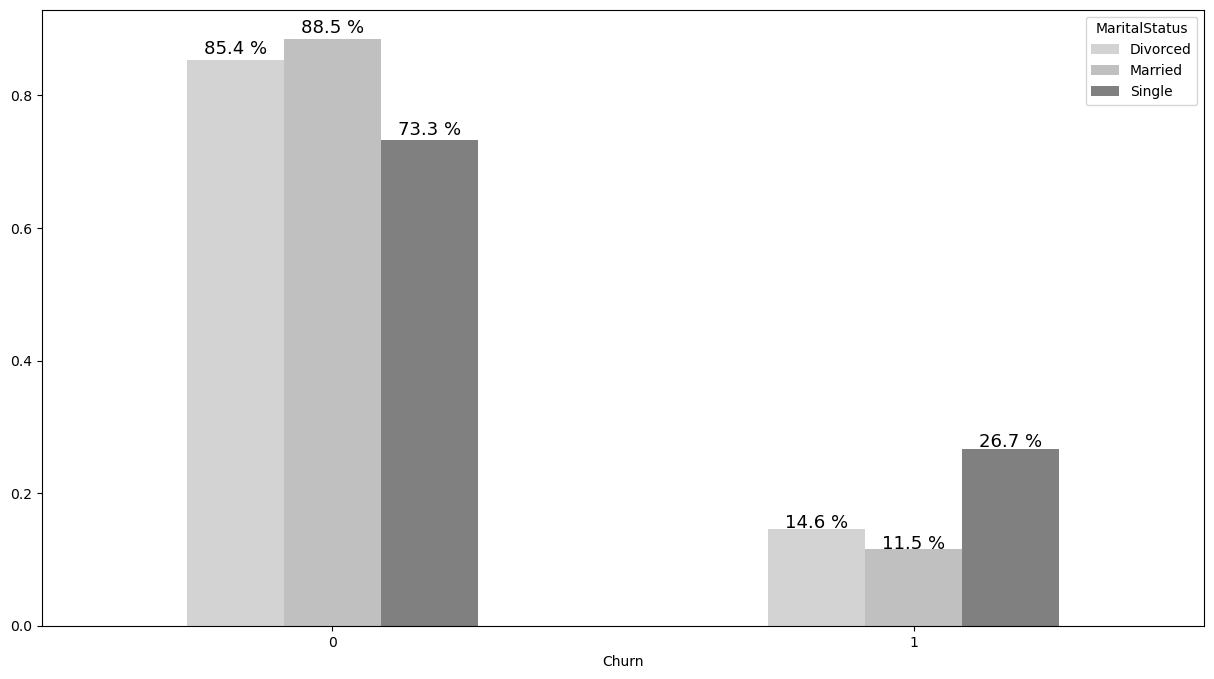

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))

# crosstab을 사용하여 정규화된 교차표 생성 및 시각화
pd.crosstab(df['MaritalStatus'], df['Churn'], normalize='index').T.plot.bar(rot=0, color=['lightgrey','silver', 'grey','dimgrey','black'], ax=ax)

# 퍼센트 값 표시
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f %%" % (height * 100), (left + width / 2, height * 1.01), ha='center',size=13)

plt.show()

### 5.도시등급에 따른 이탈 
- 도시등급 3은 이탈율이 가장 높은 지역으로, 이탈율은 약 21.4%
- 도시등급  1,2는 Mobile 카테고리를 가장 선호하며, 도시등급 3은 Laptop을 가장 선호한다. 
- 도시등급 1은 직불카드 결제 방식을 가장 선호한다. 
- 도시 등급 2는 은행 간 계좌이체 결제 방식을 가장 선호한다. 
- 도시 등급 3은  전자 지갑 시스템 결제 방식을 가장 선호한다. 


In [21]:
pd.crosstab(df['CityTier'],df['Churn'],margins=True)

Churn,0,1,All
CityTier,,,
1,3134,532,3666
2,194,48,242
3,1354,368,1722
All,4682,948,5630


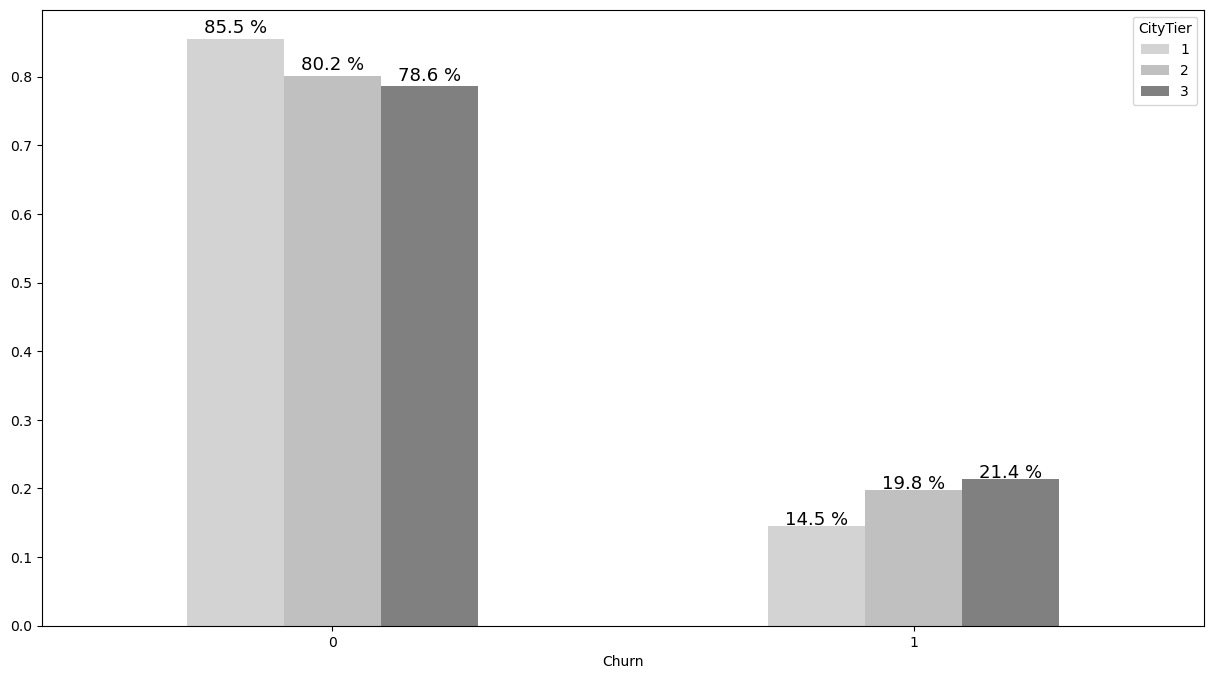

In [22]:
fig, ax = plt.subplots(figsize=(15, 8))

# crosstab을 사용하여 정규화된 교차표 생성 및 시각화
pd.crosstab(df['CityTier'], df['Churn'], normalize='index').T.plot.bar(rot=0, color=['lightgrey','silver', 'grey','dimgrey','black'], ax=ax)

# 퍼센트 값 표시
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.1f %%" % (height * 100), (left + width / 2, height * 1.01), ha='center',size=13)

plt.show()

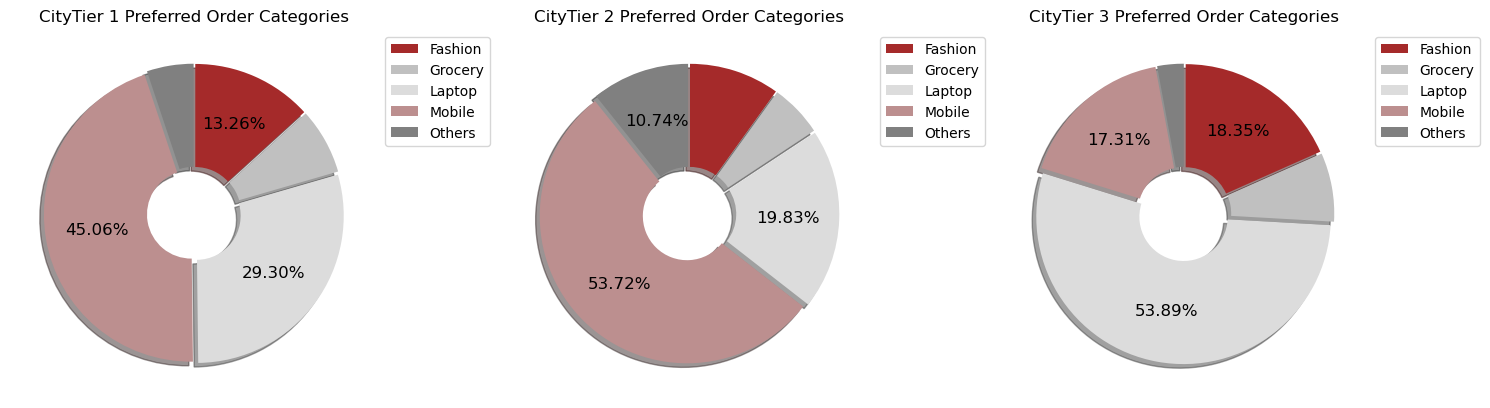

In [23]:
def plot_preferred_order_cat_pie(df, CityTier, ax):
    # 데이터 필터링 및 그룹화
    df_filtered = df[df['CityTier'] == CityTier]
    order_counts = df_filtered.groupby('PreferedOrderCat')['PreferedOrderCat'].count()
    
    # 파이 차트 설정
    colors = ['brown', 'silver', 'gainsboro', 'rosybrown','grey']
    wedgeprops = {'width': 0.7}
    explode = [0.02] * order_counts.size

    # 비율 표시를 위한 함수
    def my_autopct(pct):
        return ('%.2f%%' % pct) if pct > 10 else ''
    
    # 파이 차트 그리기
    ax.pie(order_counts, autopct=my_autopct, startangle=90, counterclock=False, 
           explode=explode, shadow=True, colors=colors, wedgeprops=wedgeprops, 
           textprops={'fontsize': 12}, pctdistance=0.65)
    
    # 범례 및 타이틀 설정
    ax.legend(order_counts.index, bbox_to_anchor=(1, 1))
    ax.set_title('Prefered Order Category Composition - CityTier {}'.format(CityTier))

# 메인 코드 부분
# fig, ax를 설정해주고, plot_preferred_order_cat_pie 함수를 호출하여 차트를 그립니다.
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# 각 CityTier에 대해 파이 차트를 그립니다.
plot_preferred_order_cat_pie(df, 1, axes[0])
plot_preferred_order_cat_pie(df, 2, axes[1])
plot_preferred_order_cat_pie(df, 3, axes[2])

# 각 축에 대한 타이틀을 설정합니다.
axes[0].set_title('CityTier 1 Preferred Order Categories')
axes[1].set_title('CityTier 2 Preferred Order Categories')
axes[2].set_title('CityTier 3 Preferred Order Categories')

# tight_layout을 사용하여 겹침을 방지합니다.
plt.tight_layout()
plt.show()

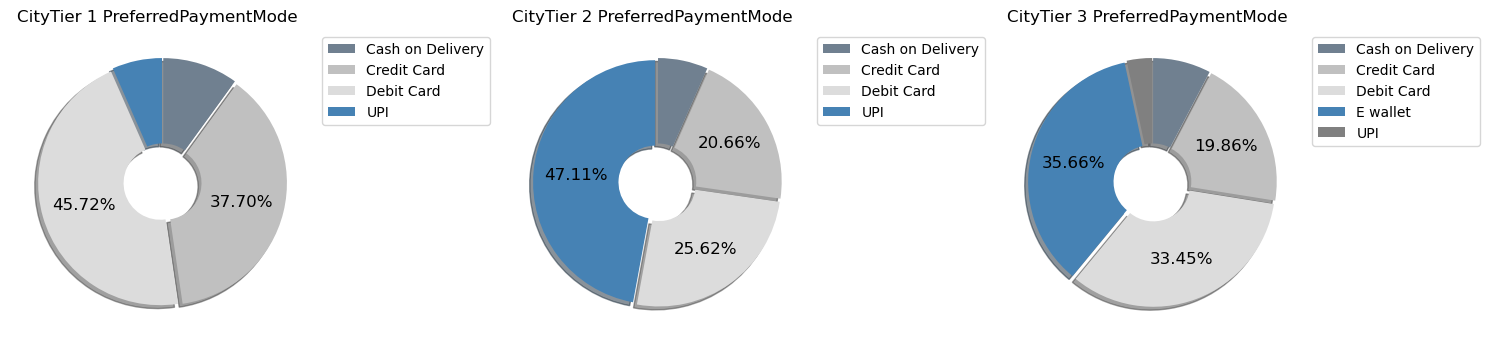

In [24]:
def plot_preferred_order_cat_pie(df, CityTier, ax):
    # 데이터 필터링 및 그룹화
    df_filtered = df[df['CityTier'] == CityTier]
    order_counts = df_filtered.groupby('PreferredPaymentMode')['PreferredPaymentMode'].count()
    
    # 파이 차트 설정
    colors = ['slategrey', 'silver', 'gainsboro', 'steelblue','grey']
    wedgeprops = {'width': 0.7}
    explode = [0.02] * order_counts.size

    # 비율 표시를 위한 함수
    def my_autopct(pct):
        return ('%.2f%%' % pct) if pct > 10 else ''
    
    # 파이 차트 그리기
    ax.pie(order_counts, autopct=my_autopct, startangle=90, counterclock=False, 
           explode=explode, shadow=True, colors=colors, wedgeprops=wedgeprops, 
           textprops={'fontsize': 12}, pctdistance=0.65)
    
    # 범례 및 타이틀 설정
    ax.legend(order_counts.index, bbox_to_anchor=(1, 1))
    ax.set_title('Prefered Order Category Composition - CityTier {}'.format(CityTier))

# 메인 코드 부분
# fig, ax를 설정해주고, plot_preferred_order_cat_pie 함수를 호출하여 차트를 그립니다.
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# 각 CityTier에 대해 파이 차트를 그립니다.
plot_preferred_order_cat_pie(df, 1, axes[0])
plot_preferred_order_cat_pie(df, 2, axes[1])
plot_preferred_order_cat_pie(df, 3, axes[2])

# 각 축에 대한 타이틀을 설정합니다.
axes[0].set_title('CityTier 1 PreferredPaymentMode  ')
axes[1].set_title('CityTier 2 PreferredPaymentMode  ')
axes[2].set_title('CityTier 3 PreferredPaymentMode  ')

# tight_layout을 사용하여 겹침을 방지합니다.
plt.tight_layout()
plt.show()

# 데이터 전처리 

In [28]:
def preprocess_data(df, encod_cols, num_cols, remove_outliers=None, scale=None):
    # 결측치 제거
    df = df.dropna()
    
    # IQR을 사용한 이상치 제거
    if remove_outliers == 'iqr' and num_cols is not None:
        Q1 = df[num_cols].quantile(0.25)
        Q3 = df[num_cols].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    # Isolation Forest를 사용한 이상치 제거
    elif remove_outliers == 'isolation_forest' and num_cols is not None:
        iso_forest = IsolationForest(contamination=0.01)
        outliers = iso_forest.fit_predict(df[num_cols].values)  # NumPy 배열로 변환
        df = df[outliers != -1]
    
    # 원-핫 인코딩
    if encod_cols is not None:
        df = pd.get_dummies(data=df, columns=encod_cols)
        
    # 스케일링
    if scale == 'minmax' and num_cols is not None:
        scaler = MinMaxScaler()
        # DataFrame 대신 NumPy 배열 사용을 위해 `.values`를 제거 (NumPy 배열을 반환하므로 필요 없음)
        df[num_cols] = scaler.fit_transform(df[num_cols])
    
    return df
# 가능한 옵션 조합 생성
remove_outliers_options = [None, 'iqr', 'isolation_forest']
scale_options = [None, 'minmax']

combinations = list(product(
    remove_outliers_options,
    scale_options
))

# 전처리된 데이터프레임을 저장할 딕셔너리
preprocessed_dfs = {}

# 인코딩할 컬럼 목록 및 수치형 컬럼 목록 정의
encod_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus', 'CityTier', 'Complain']
num_cols = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# 각 조합별 전처리 실행
for idx, combo in enumerate(combinations):
    preprocessed_df = preprocess_data(
        df.copy(),  # 원본 데이터프레임의 복사본
        encod_cols=encod_cols,
        num_cols=num_cols,
        remove_outliers=combo[0],
        scale=combo[1]
    )
    # 전처리 옵션을 추가하여 데이터프레임을 딕셔너리에 저장
    preprocessed_dfs[f'combo_{idx+1}_{combo[0]}_{combo[1]}'] = preprocessed_df


In [39]:
preprocessed_dfs.keys()

dict_keys(['combo_1_None_None', 'combo_2_None_minmax', 'combo_3_iqr_None', 'combo_4_iqr_minmax', 'combo_5_isolation_forest_None', 'combo_6_isolation_forest_minmax'])

In [40]:
for n, key in enumerate(preprocessed_dfs.keys()):
    globals()[f'df_{n}'] = preprocessed_dfs[key]

In [108]:
dataframes = {
    'df1': df_0,
    'df2': df_1,
    'df3': df_2,
    'df4': df_3,
    'df5': df_4,
    'df6':df_5}

def train_and_evaluate(df, df_name, target_column='Churn', use_smote=True, use_feature_selection=False, k_features=10):
    X = df.drop(['CustomerID', target_column], axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if use_feature_selection:
        selector = SelectKBest(score_func=f_classif, k=k_features)
        X_train = selector.fit_transform(X_train, y_train)
        X_test = selector.transform(X_test)
    
    if use_smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    results = []
    
    clf_list = [LogisticRegression(max_iter=5000), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier(), GradientBoostingClassifier()]
    clf_name_list = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'XGBClassifier', 'GradientBoostingClassifier']
    
    for clf, name in zip(clf_list, clf_name_list):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy = np.round(accuracy_score(y_test, y_pred),4)
        precision = np.round(precision_score(y_test, y_pred, zero_division=0),4)
        recall = np.round(recall_score(y_test, y_pred),4)
        f1 = np.round(f1_score(y_test, y_pred),4)
        roc_auc = np.round(roc_auc_score(y_test, y_pred),4)
        
        sampling_method = 'SMOTE' if use_smote else 'None'
        feature_selection = 'SelectKBest' if use_feature_selection else 'None'
        
        results.append({
            'Dataframe': df_name,
            'Sampling': sampling_method,
            'Feature Selection': feature_selection,
            'Classifier': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        })
    
    return pd.DataFrame(results)

# 모든 데이터 프레임에 대해 함수를 실행하고 결과를 합칩니다. 오버샘플링 적용 및 미적용, 변수 선택 적용 및 미적용
all_results = pd.DataFrame()

for df_name, df in dataframes.items():
    # 오버샘플링 및 변수 선택 적용
    result_df_with_smote_fs = train_and_evaluate(df, df_name, use_smote=True, use_feature_selection=True, k_features=10)
    # 오버샘플링만 적용
    result_df_with_smote = train_and_evaluate(df, df_name, use_smote=True, use_feature_selection=False)
    # 변수 선택만 적용
    result_df_with_fs = train_and_evaluate(df, df_name, use_smote=False, use_feature_selection=True, k_features=10)
    # 오버샘플링 및 변수 선택 미적용
    result_df_without_smote_fs = train_and_evaluate(df, df_name, use_smote=False, use_feature_selection=False)
    
    # 결과 합치기
    all_results = pd.concat([all_results, result_df_with_smote_fs, result_df_with_smote, result_df_with_fs, result_df_without_smote_fs], ignore_index=True)

# 최종 결과 출력
print(all_results)

    Dataframe Sampling Feature Selection                  Classifier  \
0         df1    SMOTE       SelectKBest         Logistic Regression   
1         df1    SMOTE       SelectKBest      Support Vector Machine   
2         df1    SMOTE       SelectKBest               Decision Tree   
3         df1    SMOTE       SelectKBest               Random Forest   
4         df1    SMOTE       SelectKBest               XGBClassifier   
..        ...      ...               ...                         ...   
139       df6     None              None      Support Vector Machine   
140       df6     None              None               Decision Tree   
141       df6     None              None               Random Forest   
142       df6     None              None               XGBClassifier   
143       df6     None              None  GradientBoostingClassifier   

     Accuracy  Precision  Recall  F1 Score  ROC AUC  
0      0.7682     0.3559  0.7850    0.4898   0.7752  
1      0.8450     0.4695  0

In [142]:
dataframes = {
    'df1': df_0,
    'df2': df_1,
    'df3': df_2,
    'df4': df_3,
    'df5': df_4,
    'df6': df_5
}

def train_and_evaluate(df, df_name, target_column='Churn', use_smote=True):
    X = df.drop(['CustomerID', target_column], axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if use_smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    results = []
    
    clf_list = [LogisticRegression(max_iter=5000), SVC(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier(), GradientBoostingClassifier()]
    clf_name_list = ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest', 'XGBClassifier', 'GradientBoostingClassifier']
    
    for clf, name in zip(clf_list, clf_name_list):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy = np.round(accuracy_score(y_test, y_pred),4)
        precision = np.round(precision_score(y_test, y_pred, zero_division=0),4)
        recall = np.round(recall_score(y_test, y_pred),4)
        f1 = np.round(f1_score(y_test, y_pred),4)
        roc_auc = np.round(roc_auc_score(y_test, y_pred),4)
        
        sampling_method = 'SMOTE' if use_smote else 'None'
        
        results.append({
            'Dataframe': df_name,
            'Sampling': sampling_method,
            'Classifier': name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'ROC AUC': roc_auc
        })
    
    return pd.DataFrame(results)

# 모든 데이터 프레임에 대해 함수를 실행하고 결과를 합칩니다. 이제 모든 경우에 SMOTE 적용
all_results = pd.DataFrame()

for df_name, df in dataframes.items():
    # SMOTE 적용
    result_df_with_smote = train_and_evaluate(df, df_name, use_smote=True)
    
    # 결과 합치기
    all_results = pd.concat([all_results, result_df_with_smote], ignore_index=True)

# 최종 결과 출력
print(all_results)


   Dataframe Sampling                  Classifier  Accuracy  Precision  \
0        df1    SMOTE         Logistic Regression    0.8914     0.6168   
1        df1    SMOTE      Support Vector Machine    0.7179     0.3121   
2        df1    SMOTE               Decision Tree    0.9629     0.8692   
3        df1    SMOTE               Random Forest    0.9656     0.9175   
4        df1    SMOTE               XGBClassifier    0.9801     0.9423   
5        df1    SMOTE  GradientBoostingClassifier    0.9086     0.7021   
6        df2    SMOTE         Logistic Regression    0.8397     0.4573   
7        df2    SMOTE      Support Vector Machine    0.8728     0.5426   
8        df2    SMOTE               Decision Tree    0.9258     0.7073   
9        df2    SMOTE               Random Forest    0.9722     0.9300   
10       df2    SMOTE               XGBClassifier    0.9801     0.9423   
11       df2    SMOTE  GradientBoostingClassifier    0.9179     0.7228   
12       df3    SMOTE         Logistic

In [143]:
# 모델 비교 (베이스 라인)
all_results.sort_values(by='F1 Score',ascending=False)[:10]

,Dataframe,Sampling,Classifier,Accuracy,Precision,Recall,F1 Score,ROC AUC
28,df5,SMOTE,XGBClassifier,0.9893,0.9649,0.9649,0.9649,0.9793
27,df5,SMOTE,Random Forest,0.9853,0.9813,0.9211,0.9502,0.9589
4,df1,SMOTE,XGBClassifier,0.9801,0.9423,0.9159,0.9289,0.9533
10,df2,SMOTE,XGBClassifier,0.9801,0.9423,0.9159,0.9289,0.9533
34,df6,SMOTE,XGBClassifier,0.9719,0.9524,0.8621,0.9050,0.9271
22,df4,SMOTE,XGBClassifier,0.9694,0.9412,0.8602,0.8989,0.9251
9,df2,SMOTE,Random Forest,0.9722,0.9300,0.8692,0.8986,0.9292
16,df3,SMOTE,XGBClassifier,0.9677,0.9512,0.8387,0.8914,0.9153
21,df4,SMOTE,Random Forest,0.9643,0.9390,0.8280,0.8800,0.9089
15,df3,SMOTE,Random Forest,0.9643,0.9500,0.8172,0.8786,0.9046


In [149]:
# 모델 적용 (df5 데이터 기준)
all_results[all_results['Dataframe']=='df5'].sort_values(by='F1 Score',ascending=False)

,Dataframe,Sampling,Classifier,Accuracy,Precision,Recall,F1 Score,ROC AUC
28,df5,SMOTE,XGBClassifier,0.9893,0.9649,0.9649,0.9649,0.9793
27,df5,SMOTE,Random Forest,0.9853,0.9813,0.9211,0.9502,0.9589
26,df5,SMOTE,Decision Tree,0.9559,0.8092,0.9298,0.8653,0.9452
29,df5,SMOTE,GradientBoostingClassifier,0.9225,0.7500,0.7368,0.7434,0.8463
24,df5,SMOTE,Logistic Regression,0.8810,0.6147,0.5877,0.6009,0.7607
25,df5,SMOTE,Support Vector Machine,0.7219,0.3357,0.8421,0.4800,0.7712


- F1 Score와 train데이터와 test데이터의 gap 이 0.01로 가장 적은  Data5 전처리 데이터로 모델 적용 

Test Set 성능:
Accuracy: 0.9893
Precision: 0.9649
Recall: 0.9649
F1 Score: 0.9649
ROC AUC Score: 0.9793
Cross-validation 평균 F1 Score: 0.9537
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       634
           1       0.96      0.96      0.96       114

    accuracy                           0.99       748
   macro avg       0.98      0.98      0.98       748
weighted avg       0.99      0.99      0.99       748



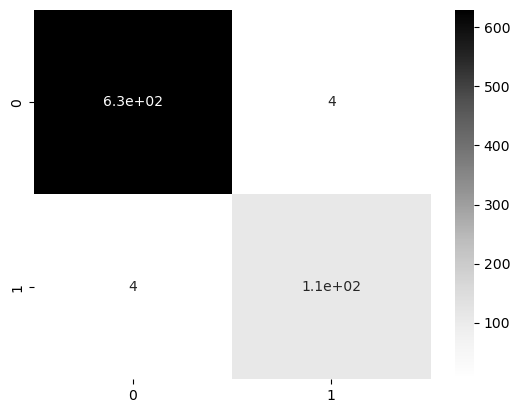

,Predicted: 0,Predicted: 1
Actual: 0,630,4
Actual: 1,4,110


In [98]:
# XGBClassifier  베이스라인 모델링 

X=df_4.drop(['Churn'],axis=1)
y=df_4['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
id=X_test.pop('CustomerID')
X_train.drop('CustomerID',axis=1,inplace=True)


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


# 모델 생성
model = XGBClassifier()

# 일반화 성능 확인: 테스트 데이터셋에 대한 성능 평가
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
accuracy_test =np.round( accuracy_score(y_test, y_pred_test),4)
precision_test =np.round(precision_score(y_test, y_pred_test),4)
recall_test = np.round(recall_score(y_test, y_pred_test),4)
f1_test =np.round( f1_score(y_test, y_pred_test),4)
roc_auc_test =np.round( roc_auc_score(y_test, y_pred_test),4)

print("Test Set 성능:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)
print("ROC AUC Score:", roc_auc_test)

# Cross-validation을 통한 검증
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')  # F1 Score를 사용하여 교차 검증 수행
print("Cross-validation 평균 F1 Score:", np.round(cv_scores.mean(),4))

print(classification_report(y_test, y_pred_test))

# Check the confusion matrix of the model
cm1 = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm1, annot=True,cmap='Greys')
plt.show()

# Create a DataFrame to display the confusion matrix with predicted and actual axis labels
cm_df1 = pd.DataFrame(cm1, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
display(cm_df1)

In [96]:
# 데이터 준비
X = df_4.drop('Churn', axis=1)
y = df_4['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'CustomerID' 컬럼 제거
id = X_test.pop('CustomerID')
X_train.drop('CustomerID', axis=1, inplace=True)

# # SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# XGBClassifier의 튜닝할 파라미터 지정 (세분화된 파라미터)
param_grid = {
    'max_depth': [7, 8, 9],  # 최적값 주변의 깊이 세분화
    'min_child_weight': [0.5, 1, 1.5],  # 최소 자식 가중치 주변의 값들 세분화
    'n_estimators': [90, 100, 110],  # 트리 개수 세분화
    'learning_rate': [0.04, 0.05, 0.06],  # 학습률 주변의 값을 세분화
    'colsample_bytree': [0.55, 0.6, 0.65],  # 트리별로 사용할 feature 비율 조정
    'reg_alpha': [0.05, 0.1, 0.15],  # L1 정규화 항 세분화
    'reg_lambda': [0, 0.01, 0.02],  # L2 정규화 항 세분화
    'subsample': [0.75, 0.8, 0.85],  # 부분 샘플링 비율 조정
    'colsample_bylevel': [0.95, 1.0],  # 각 레벨별로 사용할 feature 비율 조정
    'scale_pos_weight': [1]  # 클래스 불균형이 심각하지 않으면 고정값 사용
}

# XGBClassifier 인스턴스 생성
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 랜덤 서치(Randomized Search) 인스턴스 생성
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, cv=5, n_iter=50, scoring='f1', n_jobs=-1, random_state=42, verbose=3)

# 랜덤 서치 수행
random_search.fit(X_train_resampled, y_train_resampled)

# 최적 파라미터 출력
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 0.02, 'reg_alpha': 0.15, 'n_estimators': 100, 'min_child_weight': 0.5, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.55, 'colsample_bylevel': 0.95}


Test Set 성능:
Accuracy: 0.9773
Precision: 0.9533
Recall: 0.8947
F1 Score: 0.9231
ROC AUC Score: 0.9434
Cross-validation 평균 F1 Score: 0.9707
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       634
           1       0.95      0.89      0.92       114

    accuracy                           0.98       748
   macro avg       0.97      0.94      0.95       748
weighted avg       0.98      0.98      0.98       748



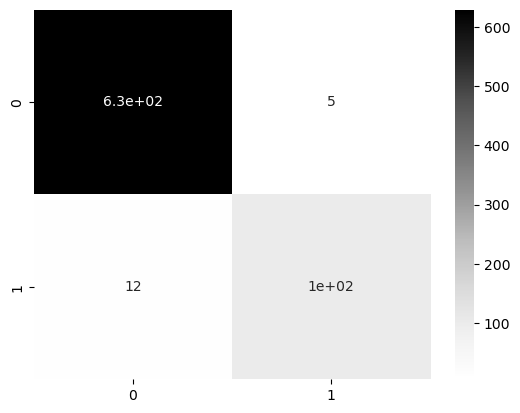

,Predicted: 0,Predicted: 1
Actual: 0,629,5
Actual: 1,12,102


In [97]:
# 베이스라인 모델링 

X=df_4.drop(['Churn'],axis=1)
y=df_4['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
id=X_test.pop('CustomerID')
X_train.drop('CustomerID',axis=1,inplace=True)


# smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


# 모델 생성
model =random_search.best_estimator_

# 일반화 성능 확인: 테스트 데이터셋에 대한 성능 평가
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
accuracy_test =np.round( accuracy_score(y_test, y_pred_test),4)
precision_test =np.round(precision_score(y_test, y_pred_test),4)
recall_test = np.round(recall_score(y_test, y_pred_test),4)
f1_test =np.round( f1_score(y_test, y_pred_test),4)
roc_auc_test =np.round( roc_auc_score(y_test, y_pred_test),4)

print("Test Set 성능:")
print("Accuracy:", accuracy_test)
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1 Score:", f1_test)
print("ROC AUC Score:", roc_auc_test)

# Cross-validation을 통한 검증
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')  # F1 Score를 사용하여 교차 검증 수행
print("Cross-validation 평균 F1 Score:", np.round(cv_scores.mean(),4))


print(classification_report(y_test, y_pred_test))

# Check the confusion matrix of the model
cm1 = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm1, annot=True,cmap='Greys')
plt.show()

# Create a DataFrame to display the confusion matrix with predicted and actual axis labels
cm_df1 = pd.DataFrame(cm1, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
display(cm_df1)

In [93]:
# 그리드 서치 
# 데이터 준비
X = df_4.drop('Churn', axis=1)
y = df_4['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 'CustomerID' 컬럼 제거
id = X_test.pop('CustomerID')
X_train.drop('CustomerID', axis=1, inplace=True)

# # SMOTE 적용
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)



# XGBClassifier 인스턴스 생성
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')



param_grid = {
    'max_depth': [8, 9],  # 최적값 주변의 깊이 세분화
    'min_child_weight': [0.25, 0.5],  # 최소 자식 가중치 주변의 값들 세분화
    'n_estimators': [90, 100],  # 트리 개수 세분화
    'learning_rate': [0.045, 0.05],  # 학습률 주변의 값을 세분화
    'colsample_bytree': [0.5, 0.55],  # 트리별로 사용할 feature 비율 조정
    'reg_alpha': [0.1, 0.15],  # L1 정규화 항 세분화
    'reg_lambda': [0.01, 0.02],  # L2 정규화 항 세분화
    'subsample': [0.75, 0.8],  # 부분 샘플링 비율 조정
    'colsample_bylevel': [0.9, 0.95],  # 각 레벨별로 사용할 feature 비율 조정
    'scale_pos_weight': [1]  # 클래스 불균형이 심각하지 않으면 고정값 사용
}



grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=3)

# 그리드 서치 수행
grid_search.fit(X_train_resampled, y_train_resampled)

# 최적 파라미터 출력
print("Best parameters found by grid search:", grid_search.best_params_)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best parameters found by grid search: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.55, 'learning_rate': 0.05, 'max_depth': 9, 'min_child_weight': 0.25, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.02, 'scale_pos_weight': 1, 'subsample': 0.8}


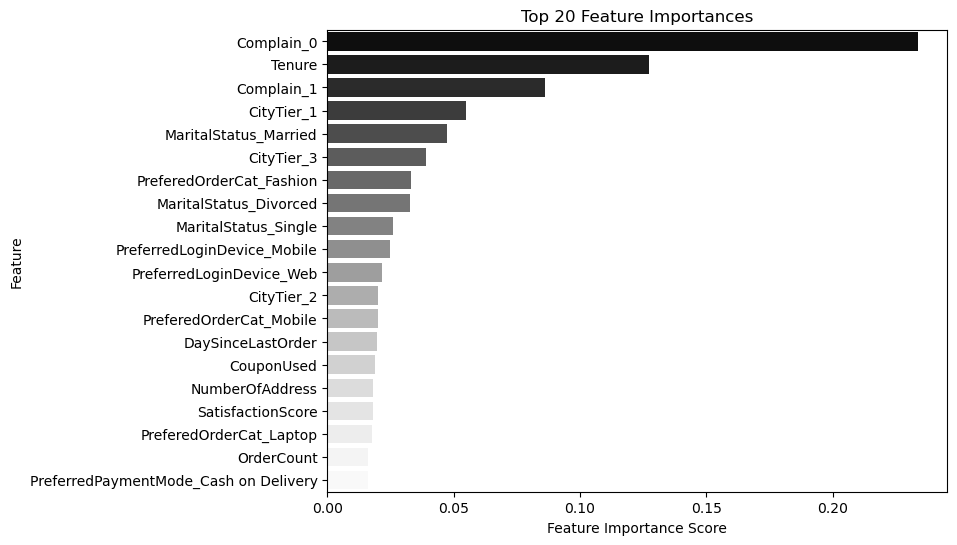

In [103]:
ftr_importances_values = model.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(8, 6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index, palette='Greys_r')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.show()

In [99]:
# Stratified K-Fold 교차 검증 설정
cv = StratifiedKFold(n_splits=10)

# 교차 검증 수행
cross_val_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')

# 결과 출력
print("Cross-validation F1 scores:", cross_val_scores)
print("Average F1 score:", cross_val_scores.mean())

Cross-validation F1 scores: [0.99525784 0.95975249 0.96082334 0.99033292 0.9762892  0.94273465
 0.96027689 0.96759139 0.96547438 0.98539717]
Average F1 score: 0.9703930261447917


In [105]:
predic_proba=model.predict_proba(X_test)

d={'CustomerID':id,'Predict':y_pred_test,'Predcit_proba':predic_proba[:,1]}
predict_churn=pd.DataFrame(d)
predict_churn=predict_churn.sort_values(by='Predcit_proba',ascending=False).reset_index(drop=True)
predict_churn['Predcit_proba']=predict_churn['Predcit_proba']*100

# 이탈 등급화 

predict_churn['rank']=0
predict_churn.loc[(predict_churn['Predcit_proba']>-0.1)&(predict_churn['Predcit_proba']<=33.333),'rank']=3
predict_churn.loc[(predict_churn['Predcit_proba']>33.333)&(predict_churn['Predcit_proba']<=66.667),'rank']=2
predict_churn.loc[(predict_churn['Predcit_proba']>66.667)&(predict_churn['Predcit_proba']<=100.0),'rank']=1


In [152]:
predict_churn[:5]

,CustomerID,Predict,Predcit_proba,rank
0,53402,1,99.993881,1
1,52821,1,99.984932,1
2,50787,1,99.982224,1
3,52257,1,99.980667,1
4,55072,1,99.977165,1
